## 有向ネットワーク上の行動採用モデルが示す爆発的拡散

### 必要なパッケージのインストール、描画の設定

In [1]:
import os

from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import xarray as xr

from utils.switch import build_network_path
from utils.calculation import sample_scale_free_degrees, theoretical_scale_free_distribution

from tqdm import tqdm

# グラフの色指定
colors = [
    "#FF6B35",  # orange
    "#00C2A8",  # teal
    "#FFB700",  # amber
    "#7B2FBE",  # medium purple
    "#00A3E0",  # sky blue
    "#E8003D",  # red
    "#330066",  # dark purple
]
markers = ["o", "^", "s", "D", "P", "X", "d", "H", "v", "p", "*"]
linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]

# グラフ全体のフォント設定
plt.rcParams['font.family'] = 'serif'  # 全体のフォントをSerifに設定
plt.rcParams['mathtext.fontset'] = 'cm'  # 数式のフォントをComputer Modernに設定
plt.rcParams['mathtext.rm'] = 'serif'  # TeXの通常フォントをSerifに設定
plt.rcParams['font.size'] = 18  # デフォルトフォントサイズ
plt.rcParams['axes.labelsize'] = 18  # 軸ラベルのフォントサイズ
plt.rcParams['axes.titlesize'] = 22  # タイトルのフォントサイズ
plt.rcParams['legend.fontsize'] = 16  # 凡例のフォントサイズ
plt.rcParams['grid.color'] = 'gray'  # グリッドの色を薄い灰色に設定
plt.rcParams['grid.linestyle'] = ':'  # グリッドを点線に設定
plt.rcParams['grid.linewidth'] = 0.5  # グリッドの線幅を設定


In [2]:
show_N = 500_000 # 頂点数
kmin = 5
kmax = 707
kave = 12.00
gamma = 2.5

# 固定パラメータ
batch_size = 16
mu = 1.0
show_T = 3

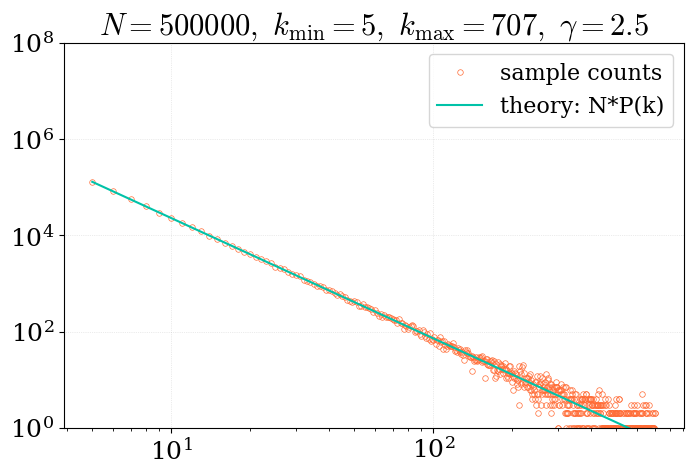

sample
 --> k_min: 5
 --> k_max: 701
 --> mean: 12.50963
theory
 --> mean: 12.503491675929613


In [3]:
n_sample = show_N # サンプル数

k_vals = np.arange(kmin, kmax + 1)
sample_k_ave, sample_counts = sample_scale_free_degrees(n_sample, kmin, kmax, gamma)
theory_k_ave, theory_pk = theoretical_scale_free_distribution(kmin, kmax, gamma)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_ylim(1e0, 1e8)
ax.loglog(k_vals, sample_counts, linestyle="", marker="o", markerfacecolor="none", color=colors[0], markersize=4, markeredgewidth=0.5, label="sample counts")
ax.loglog(k_vals, show_N * theory_pk, linestyle="-", color=colors[1], label="theory: N*P(k)")
ax.grid(True, alpha=0.3, linestyle=":")
ax.set_title(rf"$N={show_N},\ k_{{\mathrm{{min}}}}={kmin},\ k_{{\mathrm{{max}}}}={kmax},\ \gamma={gamma}$")
ax.legend()
plt.show()

print("sample")
print(" --> k_min:", kmin)
print(" --> k_max:", k_vals[sample_counts > 0].max())
print(" --> mean:", sample_k_ave)

print("theory")
print(" --> mean:", theory_k_ave)


In [31]:
pi_type = "Pow"
ebcm_dir = os.path.abspath(os.path.join("..", "out", "ebcm", "pos-comparison", "directed-infty"))
ebcm_path = os.path.join(ebcm_dir, f"{pi_type}", f"gamma={gamma:.2f}", f"kmin={kmin}", f"kmax={kmax}")
g = pd.read_csv(os.path.join(ebcm_path, "gd_zero.csv"))
g = g.set_index(["T", "rho0", "lambda_d", "mu"]).to_xarray()
theta_d_infty = g["theta_d"].squeeze()


In [32]:
df_all = pd.DataFrame()

network_path = build_network_path(N=show_N, network_type="DirectedCMInPow", k_in_min=kmin, k_in_max=kmax, gamma=gamma)
abst = "pos-comparison"
sim_path = os.path.abspath(os.path.join("..", "app", "out", "sar", f"{abst}", f"threshold={show_T}", network_path))
print(f"output_path: {os.path.relpath(sim_path)}")

for i in range(batch_size):
    index = f"{i:02d}"
    file_name = f'results_{index}.csv'
    file_path = os.path.join(sim_path, file_name)
    
    df = pd.read_csv(file_path)
    
    df["T"] = show_T
    df_all = pd.concat([df_all, df], ignore_index=True)

sim = df_all.set_index(['T', 'itr', 'rho_0', 'lambda_d', 'lambda_u', 'mu']).to_xarray()
sim_R = sim['R']
sim_Phi = sim['Phi']

output_path: ../app/out/sar/pos-comparison/threshold=3/DirectedCMInPow/N=500000/gamma=2.50/kInMin=5/kInMax=707


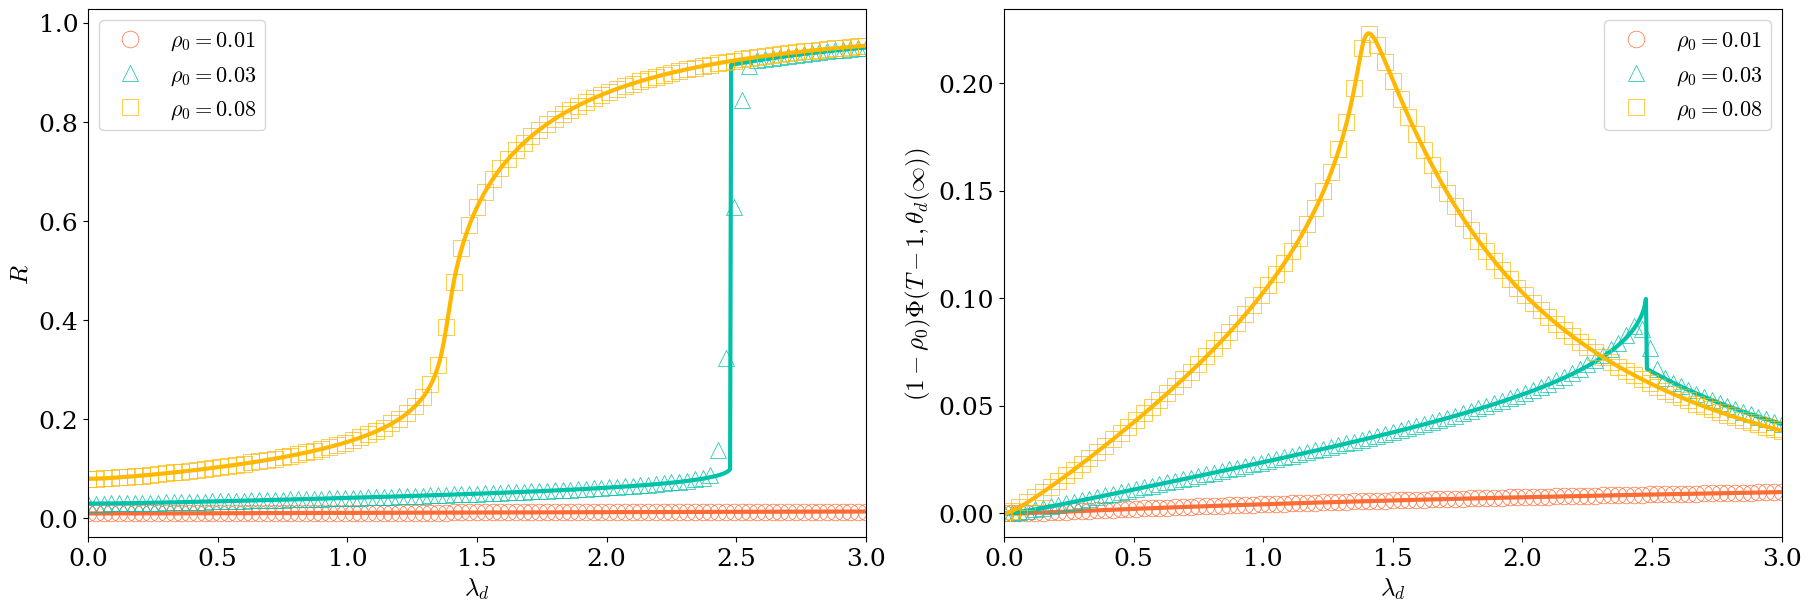

In [33]:
show_rhoo_list = [0.01, 0.03, 0.08]

fig, ax = plt.subplots(1, 2, figsize=(9*2, 6), constrained_layout=True)

for ridx, rho in enumerate(show_rhoo_list):
    sim_lambda_d_values = sim_R["lambda_d"].values
    y = sim_R.sel(rho_0=rho).squeeze().mean(dim='itr') / show_N
    ax[0].plot(
        y["lambda_d"], y,
        linestyle="", marker=markers[ridx],
        markersize=12, markerfacecolor="none",
        markeredgecolor=colors[ridx], markeredgewidth=0.5,
        label=rf"$\rho_0={rho}$"
    )

    y = sim_Phi.sel(rho_0=rho).squeeze().mean(dim='itr') / show_N
    ax[1].plot(
        y["lambda_d"], y * (1 - rho),
        linestyle="", marker=markers[ridx],
        markersize=12, markerfacecolor="none",
        markeredgecolor=colors[ridx], markeredgewidth=0.5,
        label=rf"$\rho_0={rho}$"
    )

    y = g["R"].sel(rho0=rho).sel(T=show_T).squeeze()
    ax[0].plot(
        y["lambda_d"], y,
        linestyle="-", linewidth=3.0, color=colors[ridx]
    )

    y = g["Phi"].sel(rho0=rho).sel(T=show_T).squeeze()
    ax[1].plot(
        y["lambda_d"], y * (1 - rho),
        linestyle="-", linewidth=3.0, color=colors[ridx]
    )

    ax[0].set_xlabel(rf"$\lambda_d$")
    ax[0].set_ylabel(rf"$R$")
    # ax[0].grid(linestyle="-", alpha=0.3)
    ax[0].set_xlim(min(sim_lambda_d_values), max(sim_lambda_d_values))
    ax[0].legend()

    ax[1].set_xlabel(rf"$\lambda_d$")
    ax[1].set_ylabel(rf"$(1-\rho_0)\Phi(T-1, \theta_d(\infty))$")
    # ax[1].grid(linestyle="-", alpha=0.3)
    ax[1].set_xlim(min(sim_lambda_d_values), max(sim_lambda_d_values))
    ax[1].legend()

plt.show()

/var/folders/vv/tq6tx6p94wqgdfkf0hhvjs8c0000gn/T/ipykernel_74759/1931191581.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


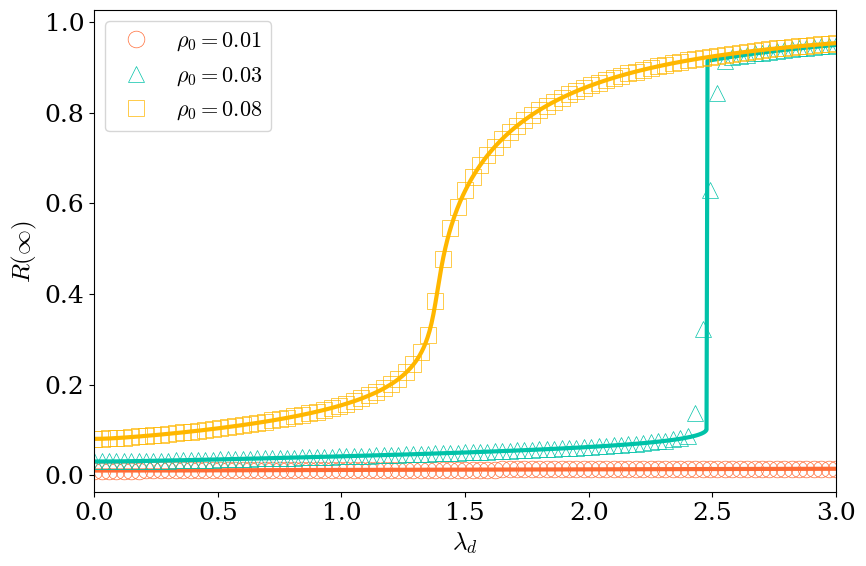

In [39]:
show_rhoo_list = [0.01, 0.03, 0.08]

fig, ax = plt.subplots(1, 1, figsize=(9, 6), constrained_layout=True)

for ridx, rho in enumerate(show_rhoo_list):
    sim_lambda_d_values = sim_R["lambda_d"].values
    y = sim_R.sel(rho_0=rho).squeeze().mean(dim='itr') / show_N
    ax.plot(
        y["lambda_d"], y,
        linestyle="", marker=markers[ridx],
        markersize=12, markerfacecolor="none",
        markeredgecolor=colors[ridx], markeredgewidth=0.5,
        label=rf"$\rho_0={rho}$"
    )

    y = g["R"].sel(rho0=rho).sel(T=show_T).squeeze()
    ax.plot(
        y["lambda_d"], y,
        linestyle="-", linewidth=3.0, color=colors[ridx]
    )

    ax.set_xlabel(rf"$\lambda_d$")
    ax.set_ylabel(rf"$R(\infty)$")
    # ax[0].grid(linestyle="-", alpha=0.3)
    ax.set_xlim(min(sim_lambda_d_values), max(sim_lambda_d_values))
    ax.legend()
plt.tight_layout()
plt.savefig("directed-ebcm-R.png", dpi=300)
plt.show()

In [7]:
ebcm_rho0_values = g["rho0"].values
ebcm_lambda_d_values = g["lambda_d"].values

gdp = pd.read_csv(os.path.join(ebcm_path, "gdp_zero.csv"))
gdp_x = np.zeros(len(ebcm_rho0_values), dtype=np.ndarray)
gdp_y = np.zeros(len(ebcm_rho0_values), dtype=np.ndarray)

gdpp = pd.read_csv(os.path.join(ebcm_path, "gdpp_zero.csv"))
gdpp_x = np.zeros(len(ebcm_rho0_values), dtype=np.ndarray)
gdpp_y = np.zeros(len(ebcm_rho0_values), dtype=np.ndarray)

gd_gdp = pd.read_csv(os.path.join(ebcm_path, "gd_gdp_zero.csv"))
gd_gdp_x = np.zeros(len(ebcm_rho0_values), dtype=np.ndarray)
gd_gdp_y = np.zeros(len(ebcm_rho0_values), dtype=np.ndarray)

gd_gdp_gdpp = pd.read_csv(os.path.join(ebcm_path, "gd_gdp_gdpp_zero.csv"))

In [8]:
lambda_c_horizontal = []
lambda_c_vertical = []

lambda_c2_horizontal = []
lambda_c2_vertical = []

for rho0_idx, rho0 in enumerate(tqdm(ebcm_rho0_values)):
    arr1 = gd_gdp[gd_gdp["rho0"] == rho0]
    arr1 = arr1[arr1["T"] == show_T]
    arr2 = gd_gdp_gdpp[gd_gdp_gdpp["rho0"] == rho0]
    arr2 = arr2[arr2["T"] == show_T]

    cv = []
    cv2 = []
    for lambda_d_idx, lambda_d in enumerate(ebcm_lambda_d_values):
        points1 = arr1[arr1["lambda_d"] == lambda_d]
        points1 = points1[points1["T"]==show_T]
        points2 = arr2[arr2["lambda_d"] == lambda_d]
        points2 = points2[points2["T"]==show_T]
        
        if(len(points1) > 0):
            cv.append(lambda_d)

        if(len(points2) > 0):
            cv2.append(lambda_d)

    if len(cv) > 0:
        lambda_c_horizontal.append(rho0)
        lambda_c_vertical.append(max(np.array(cv)))

    if len(cv2) > 0:
        lambda_c2_horizontal.append(rho0)
        lambda_c2_vertical.append(max(np.array(cv2)))


100%|██████████| 1001/1001 [02:49<00:00,  5.92it/s]


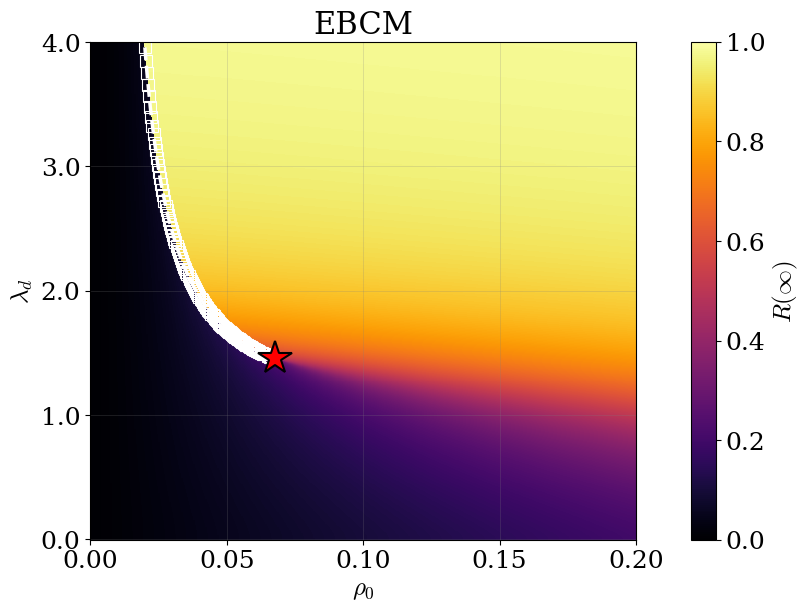

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)

p = g["R"].squeeze().T.plot(
    ax=ax,
    cmap="inferno",
    vmin=0.0,
    vmax=1.0,
    add_colorbar=False
)

ax.plot(lambda_c_horizontal, lambda_c_vertical,
        linestyle="--", color="w", linewidth=2.5,
        marker="s", markersize=8,
        markerfacecolor="none", markeredgecolor="w",
        markeredgewidth=0.8)

ax.plot(lambda_c2_horizontal, lambda_c2_vertical,
        linestyle="", marker="*", markersize=25,
        markerfacecolor="red", markeredgecolor="black",
        markeredgewidth=1.5)

ax.grid(linestyle="-", alpha=0.3)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))

ax.set_xlim(0.0, 0.2)
ax.set_title("EBCM")
ax.set_xlabel(rf"$\rho_0$")
ax.set_ylabel(rf"$\lambda_d$")

fig.colorbar(p, ax=ax, label=rf"$R(\infty)$")
plt.show()

### 次数相関がある場合

入次数と出次数を $k_{\min}=5,\ k_{\max}=707\approx\sqrt{500000},\ \gamma=2.5$ の冪則分布から独立にサンプリングしてスタブを生成する。

次に、出スタブからランダムに頂点 $i$, $j$ を選び、それぞれの入次数・出次数 $(k_i^{\rm in},\ k_i^{\rm out})$, $(k_j^{\rm in},\ k_j^{\rm out})$ について、出次数の大小関係と入次数の大小関係が**不一致**のとき（すなわち $k_i^{\rm out} > k_j^{\rm out}$ かつ $k_i^{\rm in} < k_j^{\rm in}$、またはその逆）に $i$ と $j$ の入次数を交換する。これを `swap_num` 回繰り返すことで、同一ノードの入次数と出次数に**正の相関**を注入する。

In [24]:
pi_type = "Pow"
same_in_out_dir = os.path.abspath(os.path.join("..", "out", "ebcm", "same-in-out"))
# same_in_out_dir = os.path.abspath(os.path.join("..", "out", "ebcm", "pos-comparison", "same-in-out"))
same_in_out_path = os.path.join(same_in_out_dir, f"{pi_type}", f"gamma={gamma:.2f}", f"kmin={kmin}", f"kmax={kmax}")
same_in_out_g = pd.read_csv(os.path.join(same_in_out_path, "gd_zero.csv"))
same_in_out_g = same_in_out_g.set_index(["T", "rho0", "lambda_d", "mu"]).to_xarray()


In [22]:
batch_size = 16
swap_num_list = [0, 10000, 100000, 1000000]
df_all = pd.DataFrame()

for swap_num_idx, swap_num in enumerate(swap_num_list):
    network_path = build_network_path(N=show_N, network_type="PowPow", kd_min=kmin, kd_max=kmax, gamma=gamma, swap_num=swap_num)
    abst = "check-sim2"
    sim_path = os.path.abspath(os.path.join("..", "app", "out", "sar", f"{abst}", f"threshold={show_T}", network_path))
    print(f"output_path: {os.path.relpath(sim_path)}")

    for i in range(batch_size):
        index = f"{i:02d}"
        file_name = f'results_{index}.csv'
        file_path = os.path.join(sim_path, file_name)
        
        df = pd.read_csv(file_path)
        if df is None:
            continue
        
        df["T"] = show_T
        df["network_type"] = "PowPow"
        df["swap_num"] = swap_num
        df_all = pd.concat([df_all, df], ignore_index=True)

additional_network_types = ["SameInOut"]

for additional_network_type in additional_network_types:
    network_path = build_network_path(N=show_N, network_type=additional_network_type, kd_min=kmin, kd_max=kmax, gamma=gamma, k_in_min=kmin, k_in_max=kmax)
    abst = "check-sim2"
    sim_path = os.path.abspath(os.path.join("..", "app", "out", "sar", f"{abst}", f"threshold={show_T}", network_path))
    print(f"output_path: {os.path.relpath(sim_path)}")

    for i in range(batch_size):
        index = f"{i:02d}"
        file_name = f'results_{index}.csv'
        file_path = os.path.join(sim_path, file_name)
        
        df = pd.read_csv(file_path)
        if df is None:
            continue
        
        df["T"] = show_T
        df["network_type"] = additional_network_type
        df["swap_num"] = 0
        df_all = pd.concat([df_all, df], ignore_index=True)

df_all["N"] = show_N
sim = df_all.set_index(['N', 'T', 'itr', 'rho_0', 'lambda_d', 'lambda_u', 'mu', 'network_type', 'swap_num']).to_xarray()
initial_adopted_time = sim['initial_adopted_time']
final_adopted_time = sim['final_adopted_time']
sim_R = sim['R']
sim_Phi = sim['Phi']

lambda_d_values = sim_R["lambda_d"].values
rho_0_values = sim_R["rho_0"].values

output_path: ../app/out/sar/check-sim2/threshold=3/PowPow/N=500000/gamma=2.50/kdMin=5/kdMax=707/swapNum=0
output_path: ../app/out/sar/check-sim2/threshold=3/PowPow/N=500000/gamma=2.50/kdMin=5/kdMax=707/swapNum=10000
output_path: ../app/out/sar/check-sim2/threshold=3/PowPow/N=500000/gamma=2.50/kdMin=5/kdMax=707/swapNum=100000
output_path: ../app/out/sar/check-sim2/threshold=3/PowPow/N=500000/gamma=2.50/kdMin=5/kdMax=707/swapNum=1000000
output_path: ../app/out/sar/check-sim2/threshold=3/SameInOut/N=500000/gamma=2.50/kdMin=5/kdMax=707


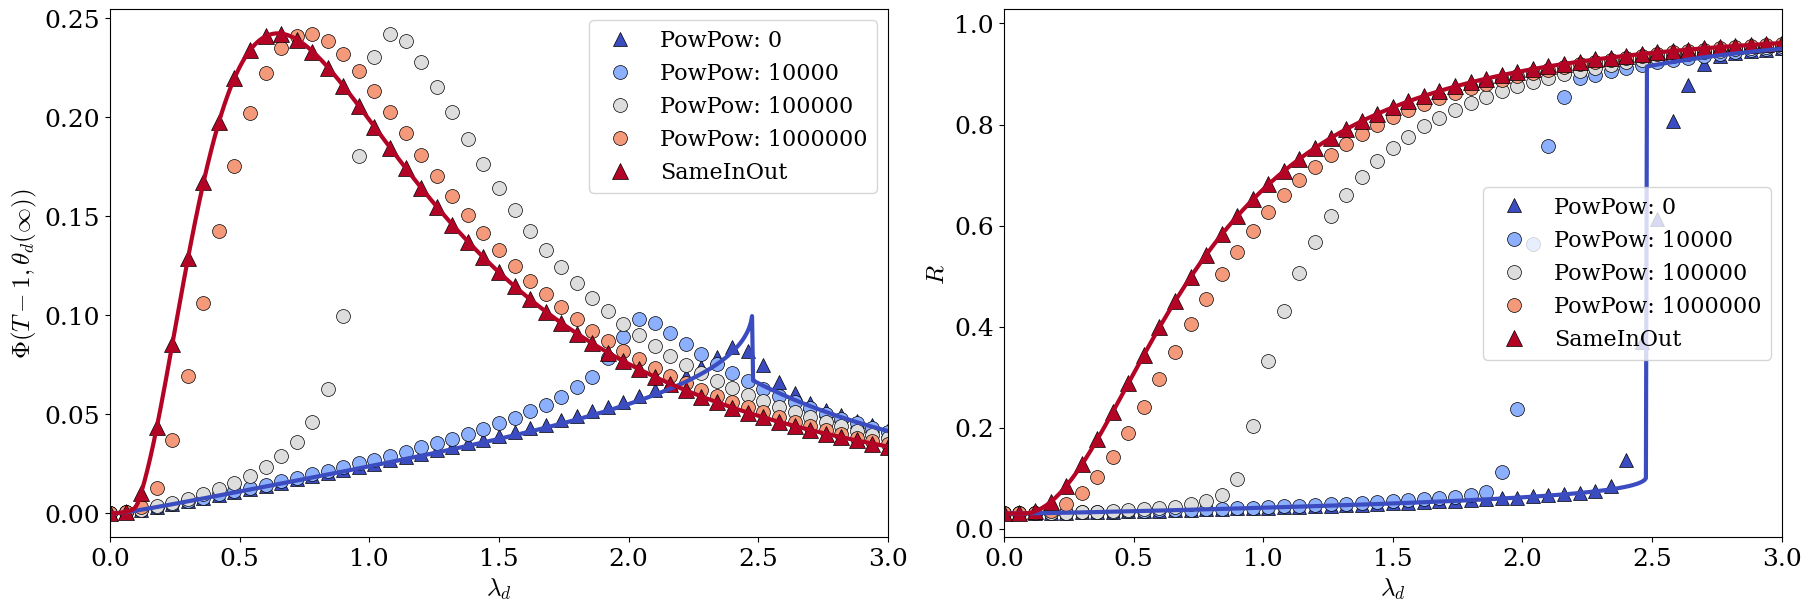

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(9*2, 6), constrained_layout=True)

swap_cmap = plt.get_cmap("coolwarm", len(swap_num_list)+1)
colors_swap = [swap_cmap(i) for i in range(len(swap_num_list)+1)]

for swap_num_idx, swap_num in enumerate(swap_num_list):
    curr_color = colors_swap[swap_num_idx]
    curr_marker = markers[0] if swap_num != 0 else markers[1]
    rho = rho_0_values[0]
    y = sim_Phi.sel(network_type="PowPow").sel(rho_0=rho).sel(swap_num=swap_num).squeeze().mean(dim='itr') / show_N
    ax[0].plot(
        lambda_d_values, y,
        linestyle="", marker=curr_marker,
        markersize=10, markerfacecolor=curr_color,
        markeredgecolor="black", markeredgewidth=0.5,
        label=f"PowPow: {swap_num}"
    )

    y = sim_R.sel(network_type="PowPow").sel(rho_0=rho).sel(swap_num=swap_num).squeeze().mean(dim='itr') / show_N
    ax[1].plot(
        lambda_d_values, y,
        linestyle="", marker=curr_marker,
        markersize=10, markerfacecolor=curr_color,
        markeredgecolor="black", markeredgewidth=0.5,
        label=f"PowPow: {swap_num}"
    )

for nidx, additional_network_type in enumerate(additional_network_types):
    y = sim_Phi.sel(network_type=additional_network_type).sel(rho_0=rho).sel(swap_num=0).squeeze().mean(dim='itr') / show_N
    ax[0].plot(
        lambda_d_values, y,
        linestyle="", marker=markers[1],
        markersize=12, markerfacecolor=colors_swap[-1],
        markeredgecolor="black", markeredgewidth=0.5,
        label=f"{additional_network_type}"
    )

    y = sim_R.sel(network_type=additional_network_type).sel(rho_0=rho).sel(swap_num=0).squeeze().mean(dim='itr') / show_N
    ax[1].plot(
        lambda_d_values, y,
        linestyle="", marker=markers[1],
        markersize=12, markerfacecolor=colors_swap[-1],
        markeredgecolor="black", markeredgewidth=0.5,
        label=f"{additional_network_type}"
    )

if show_T != 1:
    y = g["Phi"].sel(rho0=rho).sel(T=show_T).squeeze()
    ax[0].plot(
        y["lambda_d"], y,
        linestyle="-", linewidth=3.0, color=colors_swap[0]
    )

    y = g["R"].sel(rho0=rho).sel(T=show_T).squeeze()
    ax[1].plot(
        y["lambda_d"], y,
        linestyle="-", linewidth=3.0, color=colors_swap[0]
    )

    y = same_in_out_g["Phi"].sel(rho0=rho).sel(T=show_T).squeeze()
    ax[0].plot(
        y["lambda_d"], y,
        linestyle="-", linewidth=3.0, color=colors_swap[-1]
    )

    y = same_in_out_g["R"].sel(rho0=rho).sel(T=show_T).squeeze()
    ax[1].plot(
        y["lambda_d"], y,
        linestyle="-", linewidth=3.0, color=colors_swap[-1]
    )

ax[0].set_xlabel(rf"$\lambda_d$")
ax[0].set_ylabel(rf"$\Phi(T-1, \theta_d(\infty))$")
# ax[0].grid(linestyle="-", alpha=0.3)
ax[0].set_xlim(min(lambda_d_values), max(lambda_d_values))
ax[0].legend()

ax[1].set_xlabel(rf"$\lambda_d$")
ax[1].set_ylabel(rf"$R$")
# ax[1].grid(linestyle="-", alpha=0.3)
ax[1].set_xlim(min(lambda_d_values), max(lambda_d_values))
ax[1].legend()

plt.show()